<a href="https://colab.research.google.com/github/Phonchanit/python_dataviz2024/blob/main/final_dataviz_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

โหลดข้อมูล Metabolites จำนวน 51 samples จาก https://drive.google.com/drive/folders/18BGc4-dxHwuSB6ep3PmHa688Fiww23CI?usp=sharing
ซี่งประกอบด้วยค่า X ขนาด 51x65536 ซึ่งเป็นค่าความเข้มข้นขององค์ประกอบ และ ppm ขนาด 65536 ซึ่งเป็นค่า Chemical shift
ดังรูป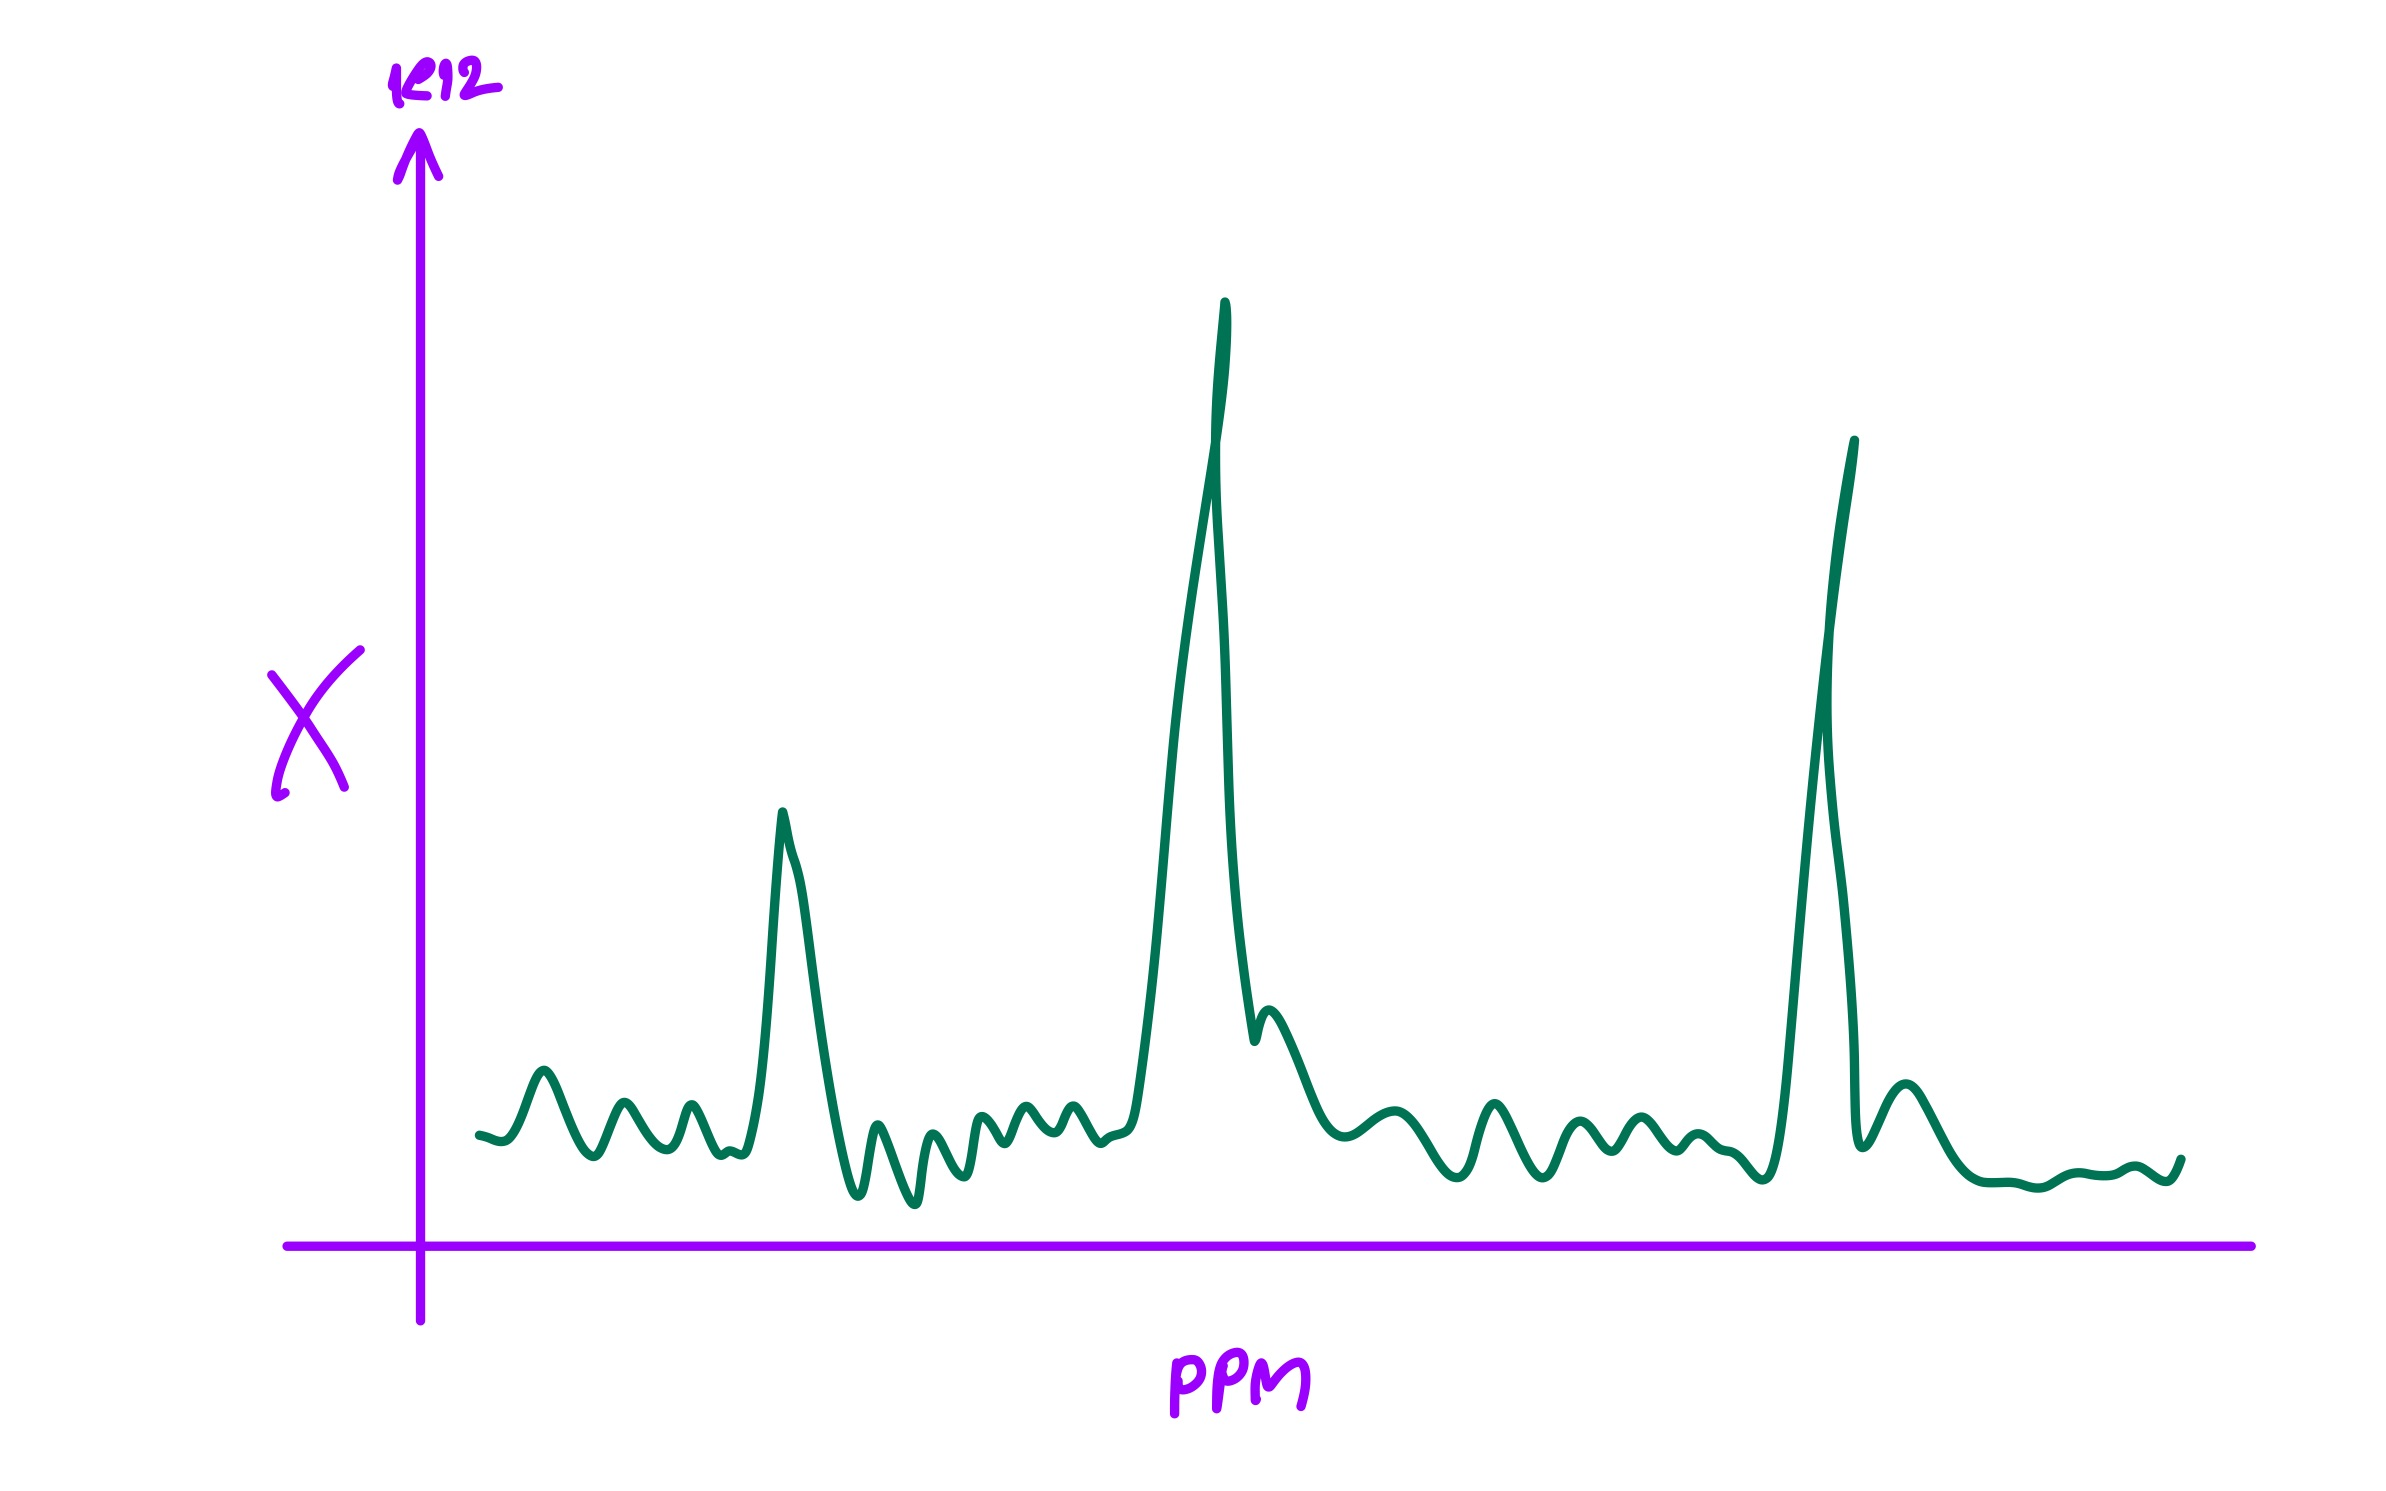

จัดการข้อมูลโดย 1 ตัด ข้อมูลที่อยู่นอกช่วงที่สนใจ (ppm $\leq$ 0 และ ppm $\geq$ 9.5)
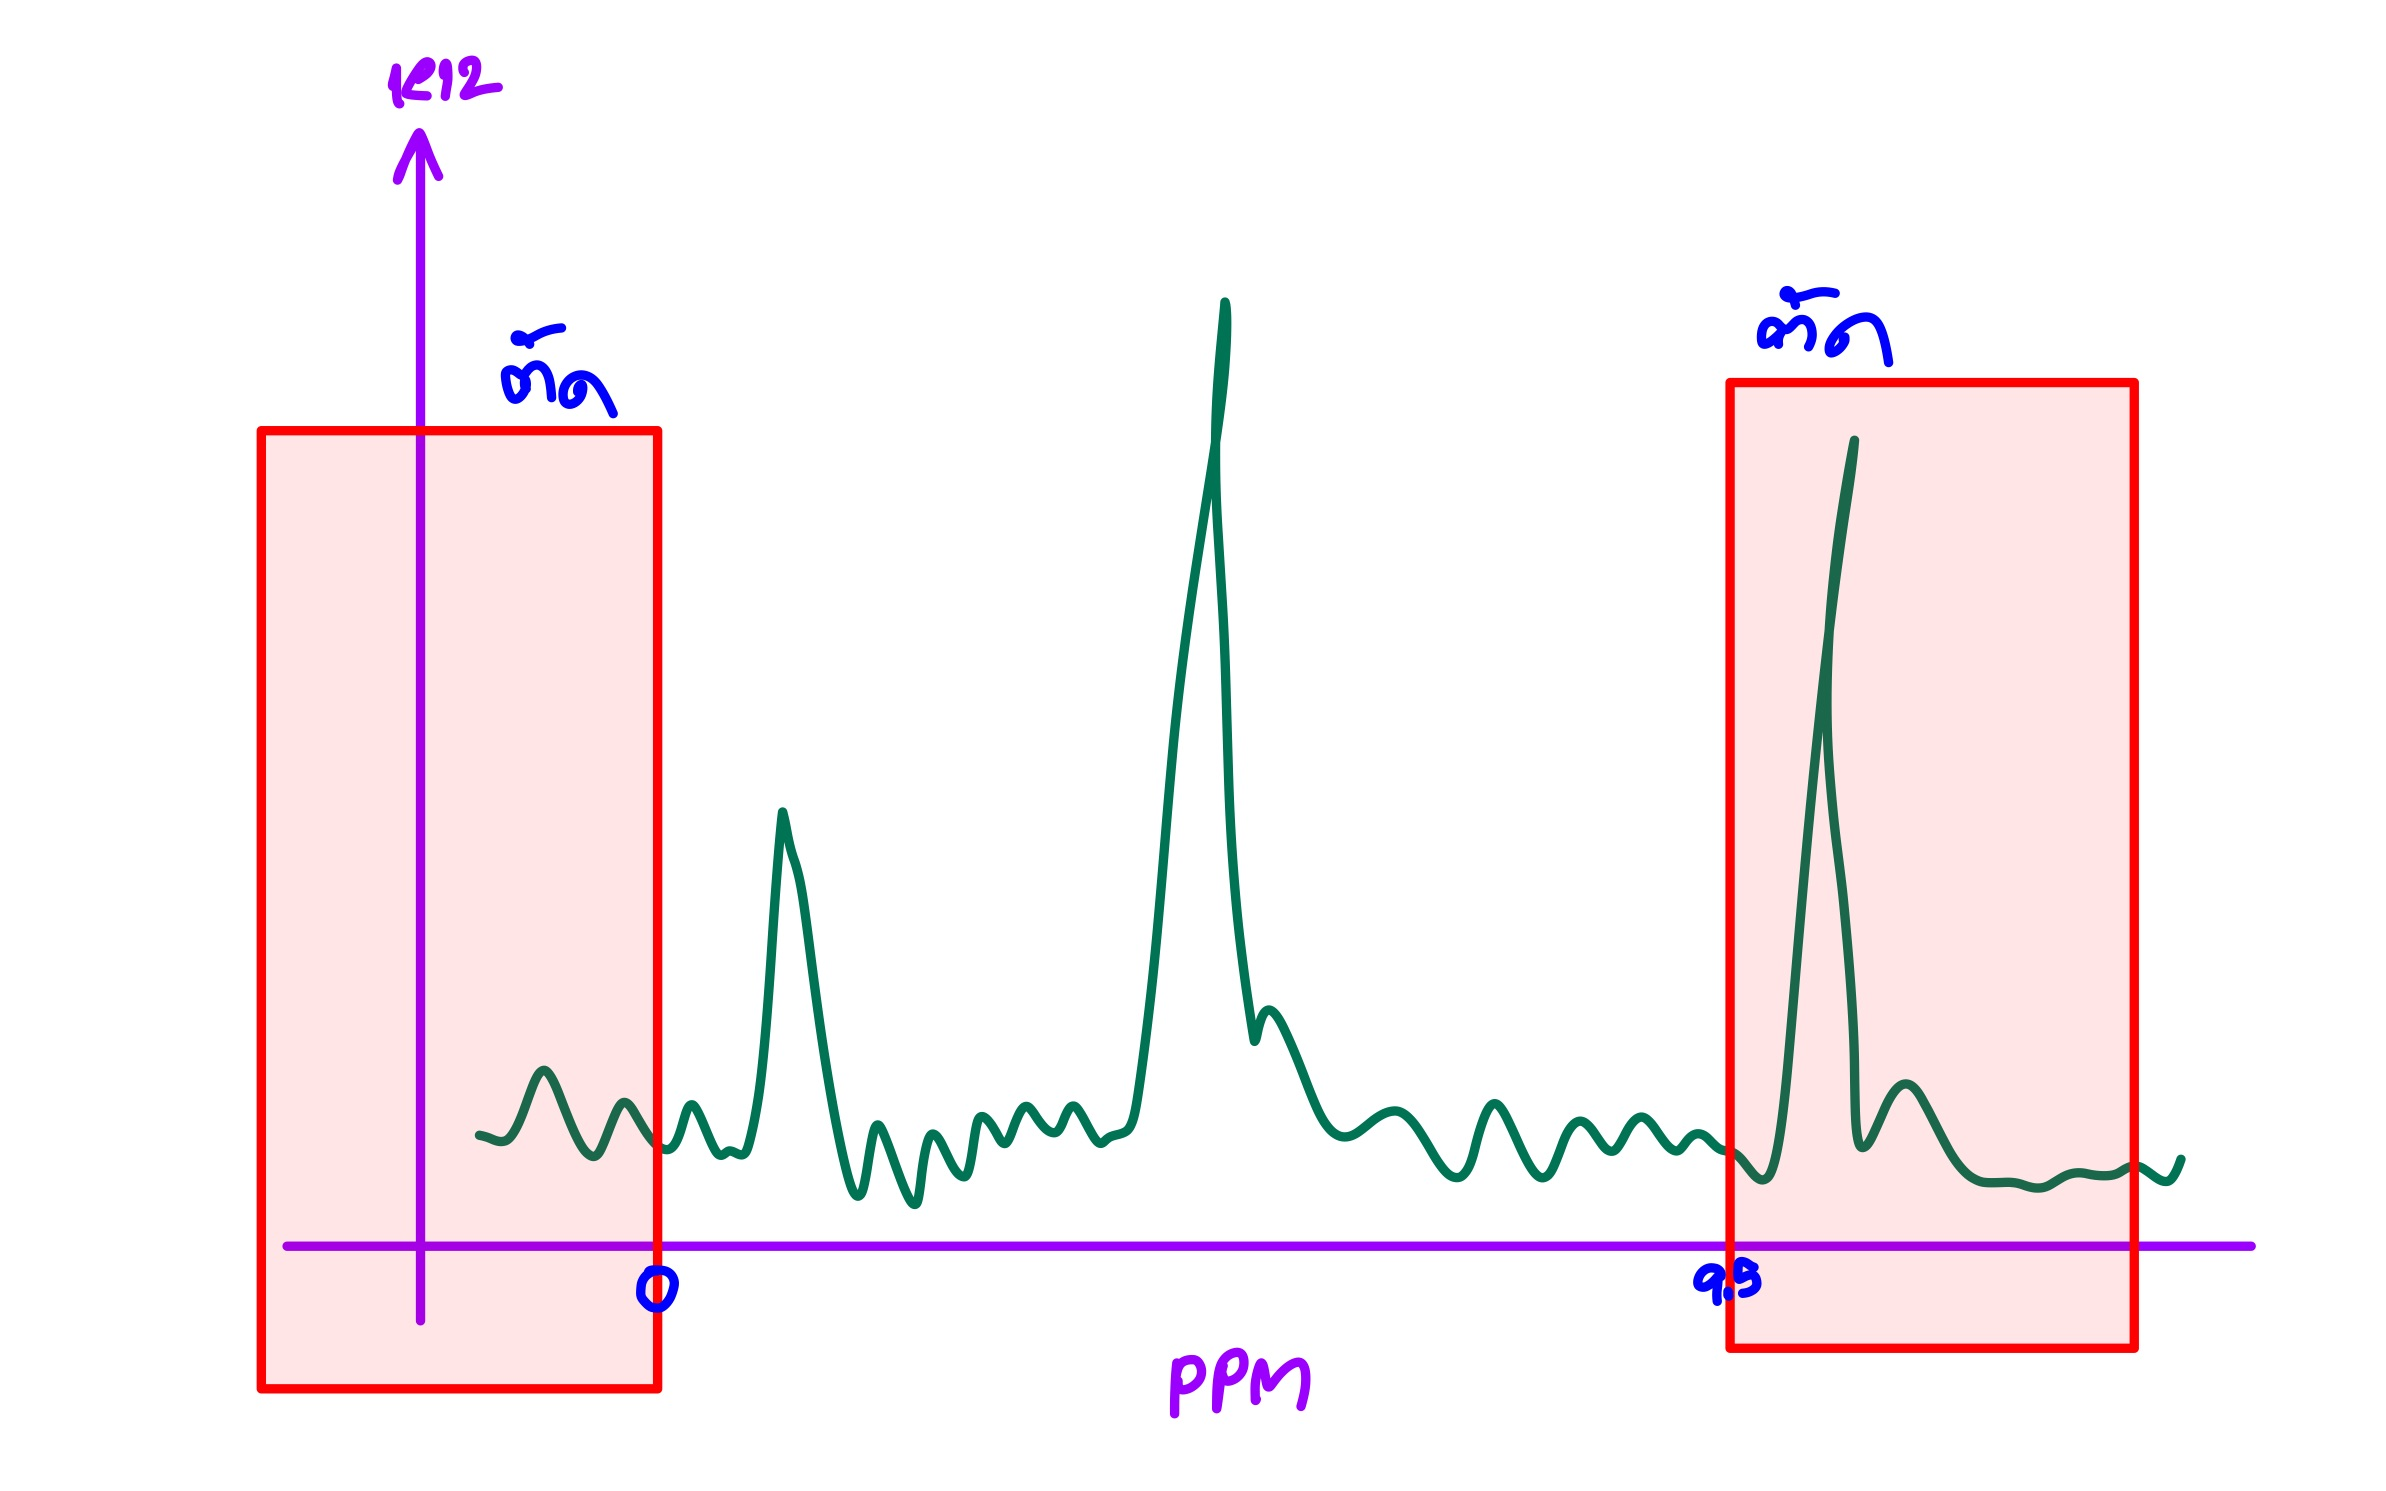

และ 2 quantize ข้อมูลโดยลดจำนวนข้อมูล ให้เหลือเพียง 51 x 400 โดยรวมข้อมูลที่อยู่ข้างกันและเลือกค่า max X
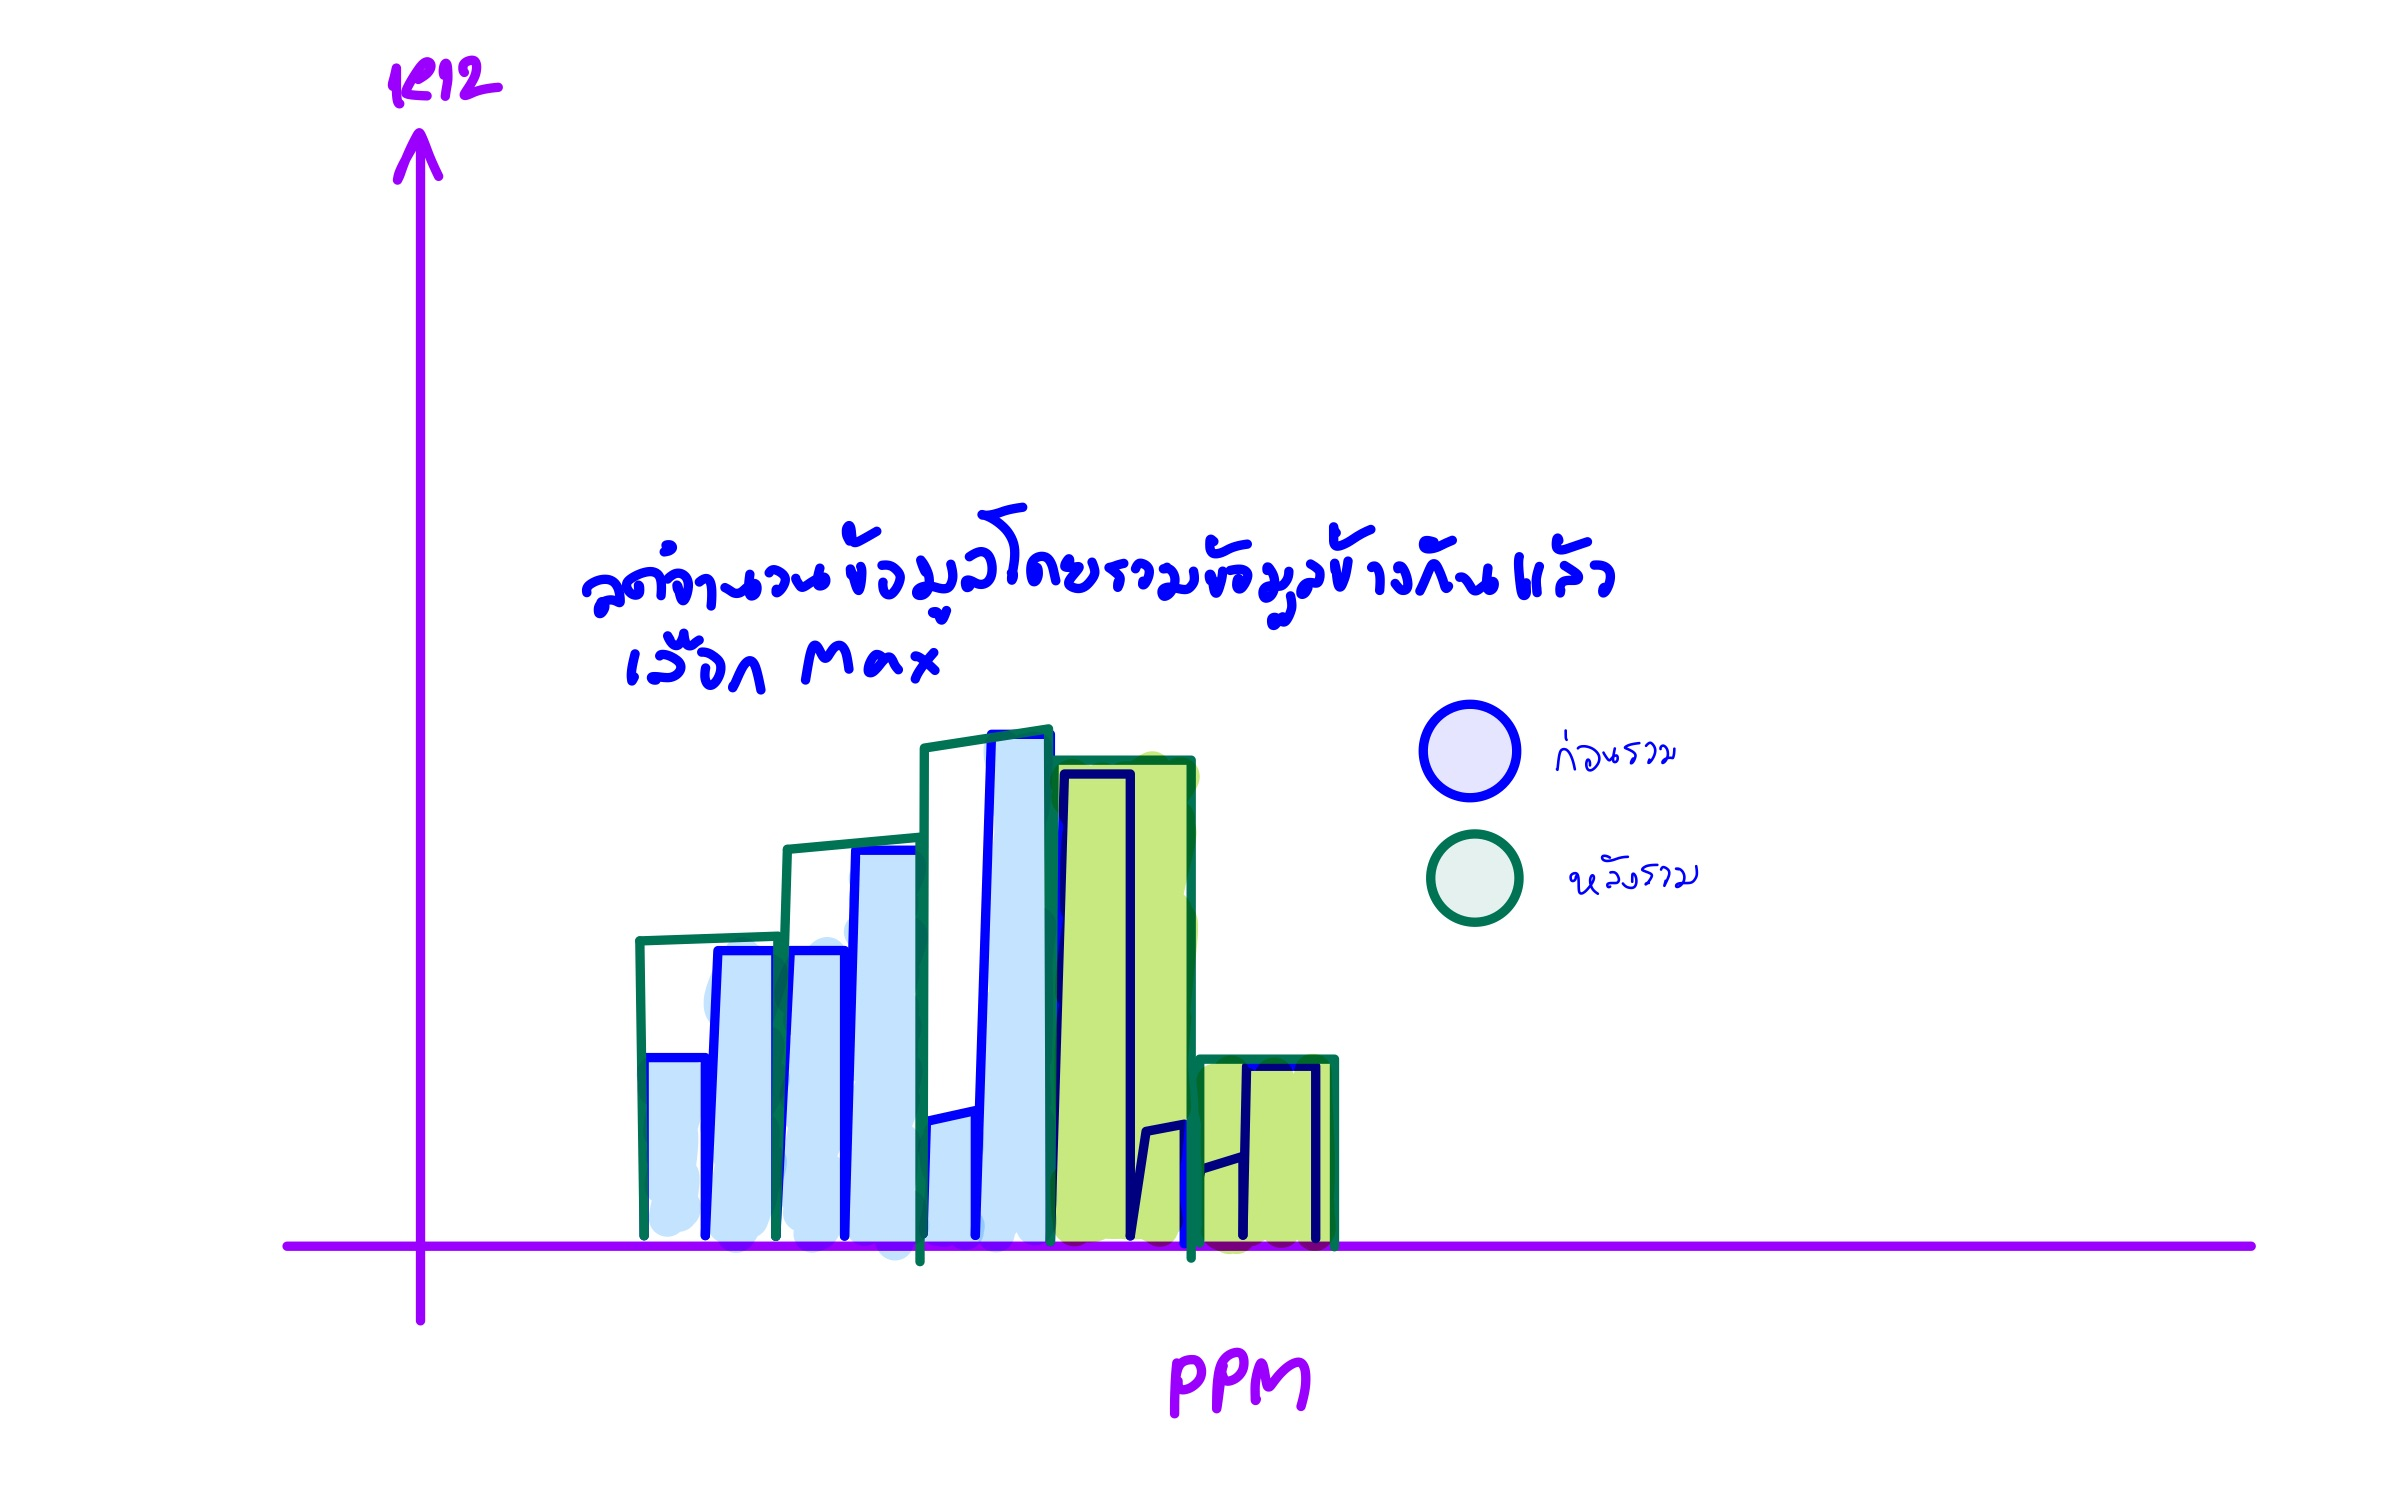

ข้อสอบ
0. preprocess ข้อมูลตามคำแนะนำข้างบน
1. ทำ PCA ข้อมูลเพื่อให้สามารถ visualize ได้
2. visualize ข้อมูลทั้ง 51 จุด เพื่อดูการจัดกลุ่มของข้อมูลเบื้องต้น
3. ตอบคำถามว่า data มีทั้งหมดกี่กลุ่ม โดย plot จุดข้อมูลแต่ละกลุ่มเป็นคนละสี
4. สร้าง ตารางที่มี column บอกว่า data แต่ละจุดนั้นอยู่กลุ่มไหน

# **Preprocess ข้อมูล**

In [1]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# prompt: นำเข้าไฟล์ .pickle และดูโครงร้างข้อมูล

import pickle

# เปลี่ยน path ตามที่ไฟล์ .pickle ของคุณอยู่
with open('/content/drive/My Drive/Multi_Dataset/Final Metabolites Data/Xnn_ppm.pickle', 'rb') as f:
  data = pickle.load(f)

In [11]:
# ดูประเภทข้อมูล
print(type(data))

<class 'tuple'>


In [19]:
# prompt: สร้าง dataframe สำหรับเก็บข้อมูล

import pandas as pd

# สร้าง DataFrame จากข้อมูล
df_data = pd.read_pickle('/content/drive/My Drive/Multi_Dataset/Final Metabolites Data/Xnn_ppm.pickle')

In [20]:
# แสดง DataFrame
print(df_data)

(array([[ 1.36984969e+07,  1.36904279e+07,  1.27889682e+07, ...,
         1.88668440e+06,  3.11779437e+06,  3.34950400e+06],
       [ 8.55679993e+06,  7.90758455e+06,  7.28975667e+06, ...,
         1.36576000e+06,  1.36576000e+06,  1.36576000e+06],
       [ 4.74035200e+06,  4.74035200e+06,  4.74035200e+06, ...,
        -2.02200274e+06, -2.32252840e+06, -3.07843664e+06],
       ...,
       [ 3.86329400e+07,  3.86329400e+07,  3.86329400e+07, ...,
        -4.37613458e+08, -4.38095321e+08, -4.40187284e+08],
       [ 9.94168277e+05,  9.94168277e+05,  9.94168277e+05, ...,
        -4.62360904e+05,  4.27633911e+05, -1.72847014e+06],
       [-1.41491086e+05, -1.41491086e+05, -1.41491086e+05, ...,
         1.16130230e+07,  1.16073431e+07,  8.35909427e+06]]), array([10.87128   , 10.87109488, 10.87090976, ..., -1.26026981,
       -1.26045493, -1.26064005]))


In [22]:
print(type(df_data))

<class 'tuple'>


In [26]:
import numpy as np

# แยกข้อมูล array
ppm_array = df_data[1]  # สมมติว่าข้อมูล ppm อยู่ในตัวที่สองของ tuple

# สร้าง DataFrame จาก ppm_array
df_ppm = pd.DataFrame(ppm_array, columns=['ppm'])


In [28]:
# prompt: ตัดข้อมูลในช่วง ppm  ≤  0 และ ppm  ≥  9.5

# ตัดข้อมูลในช่วง ppm ≤ 0 และ ppm ≥ 9.5
df_filtered = df_ppm[(df_ppm['ppm'] > 0) & (df_ppm['ppm'] < 9.5)]

# แสดง DataFrame ที่ผ่านการตัดข้อมูลแล้ว
print(df_filtered)

            ppm
7408   9.499902
7409   9.499717
7410   9.499532
7411   9.499347
7412   9.499161
...         ...
58721  0.000776
58722  0.000591
58723  0.000406
58724  0.000221
58725  0.000036

[51318 rows x 1 columns]


In [30]:
# กำหนดขนาดของ array เป้าหมาย (51 x 400)
target_rows = 51
target_cols = 400
target_size = target_rows * target_cols

# ตรวจสอบว่าข้อมูลมีขนาดเพียงพอสำหรับการจัดกลุ่มหรือไม่
if ppm_array.size < target_size:
    raise ValueError("จำนวนข้อมูลไม่เพียงพอสำหรับการแบ่งขนาด 51 x 400")

# ตัดข้อมูลให้มีขนาดตรงกับ target size
ppm_array = ppm_array[:target_size]

# reshape array เป็นขนาด (51, 400, block_size)
block_size = ppm_array.size // target_size
ppm_blocks = ppm_array.reshape(target_rows, target_cols, block_size)

# หา max ในแต่ละบล็อก
quantized_data = ppm_blocks.max(axis=2)

# ดูผลลัพธ์ของการ quantize
print(quantized_data.shape)
print(quantized_data)

(51, 400)
[[10.87128    10.87109488 10.87090976 ... 10.79778687 10.79760175
  10.79741663]
 [10.79723151 10.79704639 10.79686126 ... 10.72373838 10.72355326
  10.72336813]
 [10.72318301 10.72299789 10.72281277 ... 10.64968988 10.64950476
  10.64931964]
 ...
 [ 7.31695231  7.31676719  7.31658207 ...  7.24345918  7.24327406
   7.24308894]
 [ 7.24290382  7.2427187   7.24253358 ...  7.16941069  7.16922557
   7.16904045]
 [ 7.16885533  7.16867021  7.16848508 ...  7.0953622   7.09517708
   7.09499195]]


# **ทำ PCA**

In [31]:
df_quantized = pd.DataFrame(quantized_data)

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ขั้นตอนที่ 1: Normalize Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_quantized)

In [36]:
# ขั้นตอนที่ 2: ทำ PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

In [37]:
# ขั้นตอนที่ 3: แปลงผลลัพธ์กลับเป็น DataFrame
df_pca = pd.DataFrame(data=pca_result, columns=['Principal Component 1', 'Principal Component 2'])

In [38]:
# ดูผลลัพธ์
print(df_pca.head())

   Principal Component 1  Principal Component 2
0              33.968311           2.417182e-14
1              32.609579          -2.596509e-15
2              31.250846          -3.253735e-14
3              29.892114          -3.676901e-14
4              28.533381           7.933067e-14


In [39]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [1.0000000e+00 5.3608266e-30]


In [44]:
print(df_pca.columns)

Index(['Principal Component 1', 'Principal Component 2', 'Cluster'], dtype='object')


# **Visualize ข้อมูลทั้ง 51 จุด เพื่อดูการจัดกลุ่มของข้อมูลเบื้องต้น**

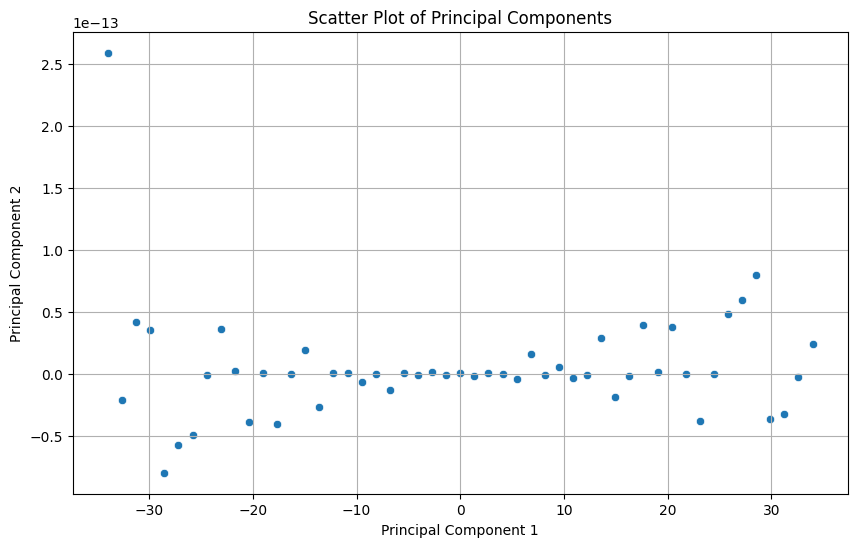

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# สร้างกราฟ Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', data=df_pca)

# กำหนดชื่อกราฟและแกน
plt.title('Scatter Plot of Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# แสดงกราฟ
plt.grid(True)
plt.show()

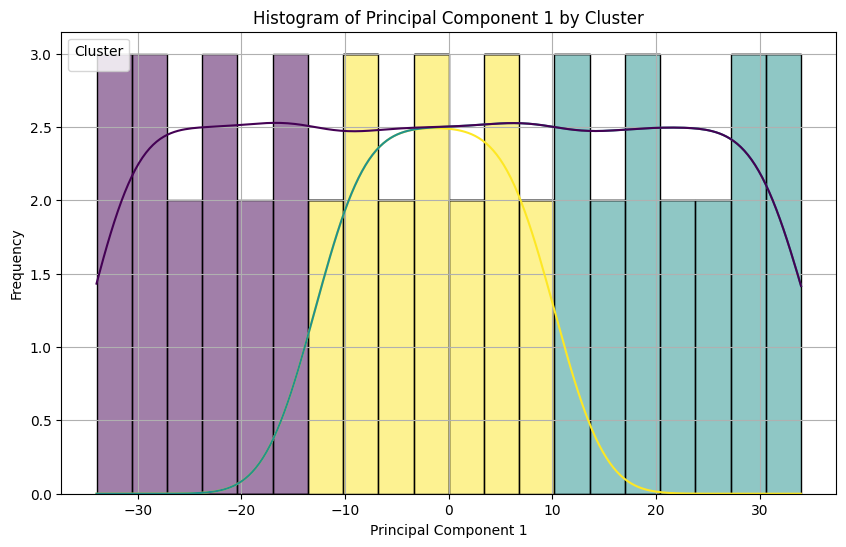

In [47]:
# สร้างกราฟ Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pca, x='Principal Component 1', hue='Cluster', multiple='stack', bins=20, palette='viridis', kde=True)

# กำหนดชื่อกราฟและแกน
plt.title('Histogram of Principal Component 1 by Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Frequency')

# แสดงกราฟ
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

In [48]:
# สรุปจำนวนกลุ่ม
num_clusters = df_pca['Cluster'].nunique()
print(f'Number of clusters: {num_clusters}')

Number of clusters: 3


# **ตอบคำถามว่า data มีทั้งหมดกี่กลุ่ม โดย plot จุดข้อมูลแต่ละกลุ่มเป็นคนละสี**

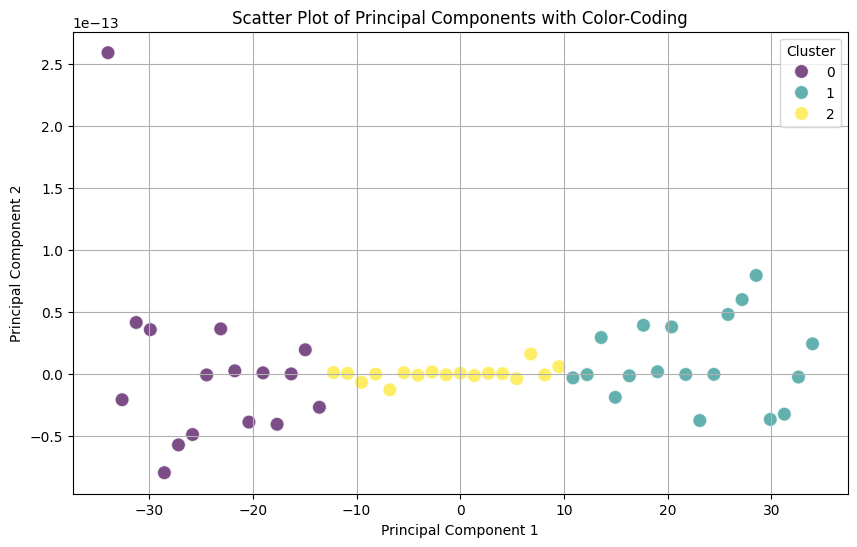

In [46]:
# สร้างกราฟ Scatter Plot โดยใช้ color-coding
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', data=df_pca, palette='viridis', s=100, alpha=0.7)

# กำหนดชื่อกราฟและแกน
plt.title('Scatter Plot of Principal Components with Color-Coding')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# แสดงกราฟ
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

**จากกราฟข้างต้น**

แกน X คือค่าของ PC1

แกน Y คือจำนวนข้อมูลในแต่ละช่วง

กำหนดให้
- สีม่วงแทนข้อมูลกลุ่มที่ 1
- สีเหลืองแทนข้อมูลกลุ่มที่ 2
- สีเขียวแทนข้อมูลกลุ่มที่ 3

จากรูปมีเส้นโค้งปรากฎ แสดงการประมาณการความหนาแน่นของข้อมูลในแต่ละกลุ่ม

สรุปได้ว่า Data มีทั้งหมด 3 กลุ่ม

**พยายามหาเหตุผลว่าทำไมถึงเป็น 3 กลุ่มและเพราะอะไร ใช้อะไรเป็นเกณฑ์**

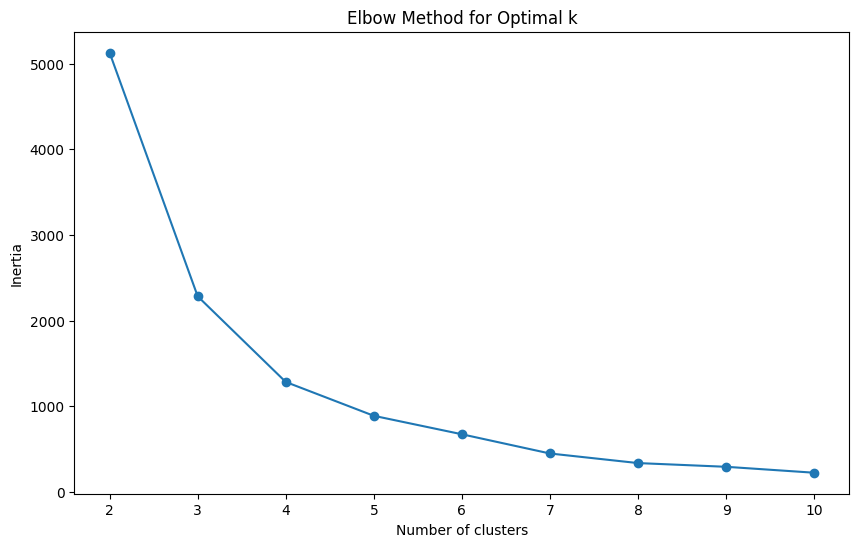

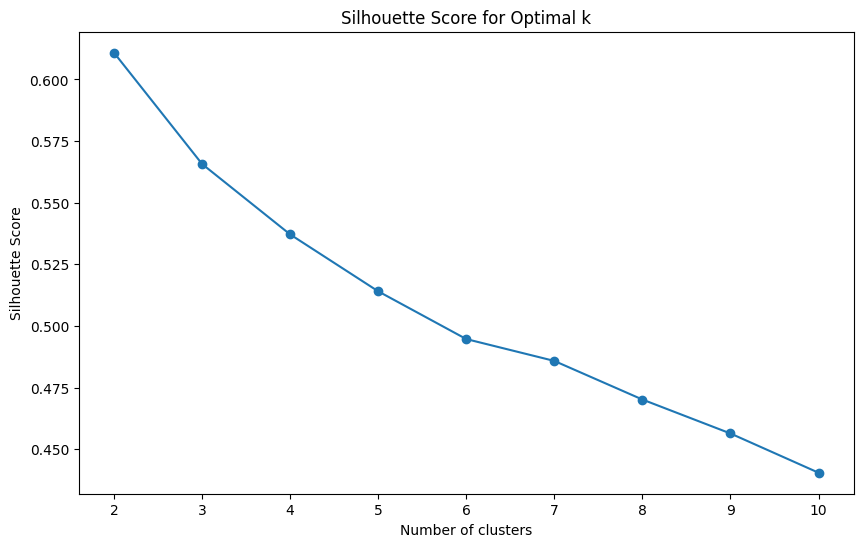

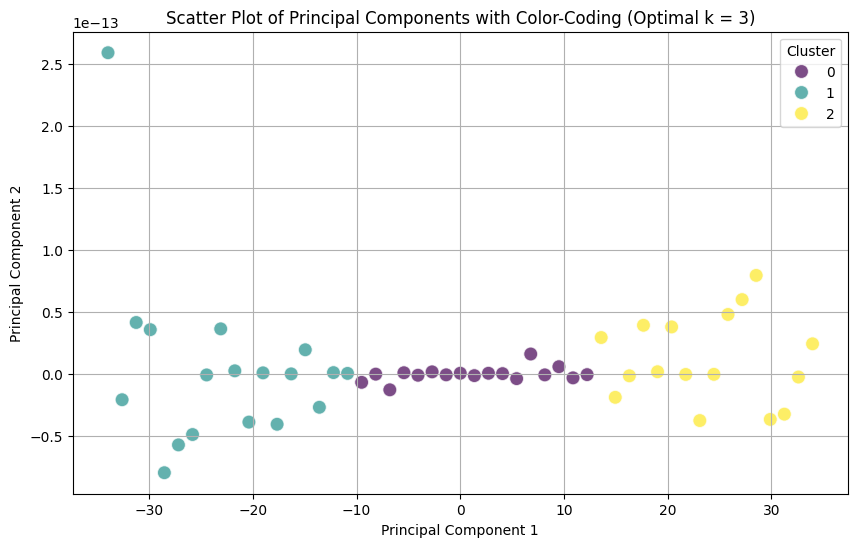

    Cluster
0         2
1         2
2         2
3         2
4         2
5         2
6         2
7         2
8         2
9         2
10        2
11        2
12        2
13        2
14        2
15        2
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
30        0
31        0
32        0
33        1
34        1
35        1
36        1
37        1
38        1
39        1
40        1
41        1
42        1
43        1
44        1
45        1
46        1
47        1
48        1
49        1
50        1


In [49]:
# prompt: ใช้เทคนิคการตรวจสอบคุณภาพของกลุ่ม (เช่น Silhouette Score)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#  ทำ K-means clustering เพื่อหาจำนวนกลุ่มที่เหมาะสม
inertia = []
silhouette_avg = []
for n_clusters in range(2, 11):  # ทดลองจำนวนกลุ่มตั้งแต่ 2 ถึง 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca)
    inertia.append(kmeans.inertia_)
    if n_clusters > 1:
        silhouette_avg.append(silhouette_score(df_pca, cluster_labels))


# Plot elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


# Plot silhouette score
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_avg, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# เลือกจำนวนกลุ่มที่เหมาะสมจาก elbow method และ silhouette score
# (อาจจะต้องพิจารณาจากทั้งสองอย่าง และเลือกจำนวนกลุ่มที่เหมาะสมที่สุด)
optimal_k = 3  # ตัวอย่าง: เลือก 3 กลุ่ม

# ทำ K-means clustering กับจำนวนกลุ่มที่เหมาะสม
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(df_pca)

# เพิ่ม column 'Cluster' ใน df_pca
df_pca['Cluster'] = cluster_labels

# plot จุดข้อมูลแต่ละกลุ่มเป็นคนละสี
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', data=df_pca, palette='viridis', s=100, alpha=0.7)

# กำหนดชื่อกราฟและแกน
plt.title('Scatter Plot of Principal Components with Color-Coding (Optimal k = {})'.format(optimal_k))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# แสดงกราฟ
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# สร้างตารางที่มี column บอกว่า data แต่ละจุดนั้นอยู่กลุ่มไหน
print(df_pca[['Cluster']])

ที่ได้ข้อมูลออกมาเป็น 3 กลุ่มอาจเพราะวิธีการจัดการกับข้อมูลอย่างการเลือกจำนวนกลุ่มในการทำ Cluster Analysis คือ ใช้วิธี k-means clustering เพราะทำให้มีผลอย่างมากต่อผลลัพธ์ จึงใช้วิธี Elbow Method มาช่วยในการตัดสินใจเลือกจำนวนกลุ่ม

จากข้อมูล Cluster ข้างต้น มีการจัดกลุ่มดังนี้

กลุ่มที่ 0: มี 34 จุด (จากดัชนี 16 ถึง 49)

กลุ่มที่ 1: มี 17 จุด (จากดัชนี 33 ถึง 50)

กลุ่มที่ 2: มี 15 จุด (จากดัชนี 0 ถึง 15)

# **สร้าง ตารางที่มี column บอกว่า data แต่ละจุดนั้นอยู่กลุ่มไหน**

In [50]:
df_cluster_assignment = pd.DataFrame({'Data Point': df_pca.index, 'Cluster': df_pca['Cluster']})

print(df_cluster_assignment)

    Data Point  Cluster
0            0        2
1            1        2
2            2        2
3            3        2
4            4        2
5            5        2
6            6        2
7            7        2
8            8        2
9            9        2
10          10        2
11          11        2
12          12        2
13          13        2
14          14        2
15          15        2
16          16        0
17          17        0
18          18        0
19          19        0
20          20        0
21          21        0
22          22        0
23          23        0
24          24        0
25          25        0
26          26        0
27          27        0
28          28        0
29          29        0
30          30        0
31          31        0
32          32        0
33          33        1
34          34        1
35          35        1
36          36        1
37          37        1
38          38        1
39          39        1
40          40  